# ZIDAS 2021: Python primer

This is a notebook demonstrating the possibilities offered by Python in the frame of bioimage processing.

## Step by step

### Importing packages

Just like Fiji has plugins, Python has packages. You can easily install them with ```conda``` and ```pip``` commands. Then, whenever you need a function of a package, you need to import it.

Usually, functions are grouped into sub-groups. For example, in the package ```skimage``` all filtering functions are grouped in the ```filters``` sub-group (or sub-module) and you use a "dot-notation", e.g. ```skimage.filters.gaussian``` to call them.

In [80]:
import skimage.io
import skimage.filters
from microfilm.microplot import microshow
import numpy as np
import matplotlib.pyplot as plt

### Set variables

Here se set important variables for our pipeline, e.g. whether we first need to filter our image or not.

In [68]:
do_median = True

### Import image

Here we import an image and have a look at it. We also create a variable that contains only the blue channel (nuclei). The images are taken from the [Human Cell Atlas](https://www.proteinatlas.org/humanproteome/cell).

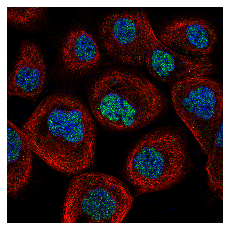

In [74]:
image = skimage.io.imread('24138_196_F7_2.tif')
im_nuclei = image[:,:,2]
microshow(np.rollaxis(image,2,0));

### Filtering

To improve the segmentation via thresholding, we first median filter the image:

In [75]:
if do_median:
    im_nuclei = skimage.filters.median(
        im_nuclei, skimage.morphology.disk(radius=5))

### Thresholding and labelling

We then use the Li thresholding method to create a binary image and then label this binary image to find connected regions.

In [76]:
# Threshold image
im_th = im_filtered > skimage.filters.threshold_li(im_filtered)

# Identify nuclei
im_labels = skimage.measure.label(im_th)

In [81]:
from microfilm.microplot import Micropanel

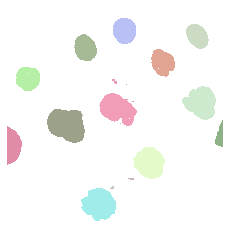

In [88]:
microshow(im_labels.astype(np.uint16), cmaps=['segmentation']);

### Properties

We can  now analyze the properties of the regions using the ```skimage.measure.regionprops_table``` function which does the same work as the "Analyze Particles" function of Fiji:

In [77]:
props = skimage.measure.regionprops_table(
    label_image=im_labels,
    intensity_image=image[:,:,1],
    properties=('label','area','mean_intensity'))

### Postprocessing

Finally we can do some post-processing e.g. by looking at a histograme of nuclei sizes:

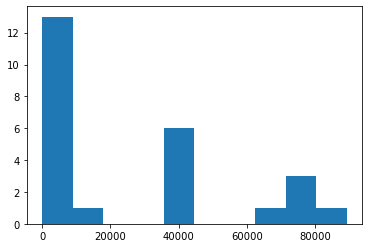

In [89]:
plt.hist(props['area']);

We see that we have a lot of isolated pixels that we should remove. We can filter our result by using logical indexing in numpy:

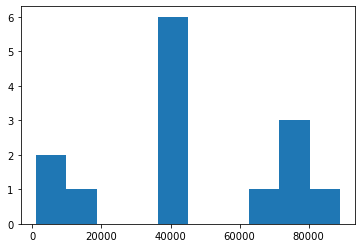

In [90]:
props_clean = props['area'][props['area'] > 1000]
plt.hist(props_clean);

## Complete routine

In [67]:
# set variables
do_median = True

# Open image
image = skimage.io.imread('24138_196_F7_2.tif')

# Extract channel
im_nuclei = image[:,:,2]

# Select nuclei (DAPI) and median filter
if do_median:
    im_nuclei = skimage.filters.median(
        im_nuclei, skimage.morphology.disk(radius=5))

# Threshold image
im_th = im_filtered > skimage.filters.threshold_li(im_filtered)

# Identify nuclei
im_labels = skimage.measure.label(im_th)

# Measure mean intensity and size in green
props = skimage.measure.regionprops_table(
    label_image=im_labels,
    intensity_image=image[:,:,1],
    properties=('label','area','mean_intensity'))

# remove small elements
props_clean = props['area'][props['area'] > 1000]